In [2]:
import matplotlib.pyplot as plt
import numpy as np
from subprocess import call
import re
from collections import OrderedDict
import math

def Clock2NanoSec(clock):
    return clock/2.801

def Clock2USec(clock):
    return clock/2801

def SigmaFilter(data):
    avg = np.average(data)
    sigma = math.sqrt(np.var(data))
    data = [x for x in data if x < avg+3*sigma and x > avg-3*sigma]
    return data

def LoadData(filepath):
    data = OrderedDict()
    for line in open(filepath).readlines():
        fields = line.split(":\t")
        samples = data.get(int(fields[0]), [])
        samples.append(Clock2USec(float(fields[1])))
        data[int(fields[0])] = samples
    return data

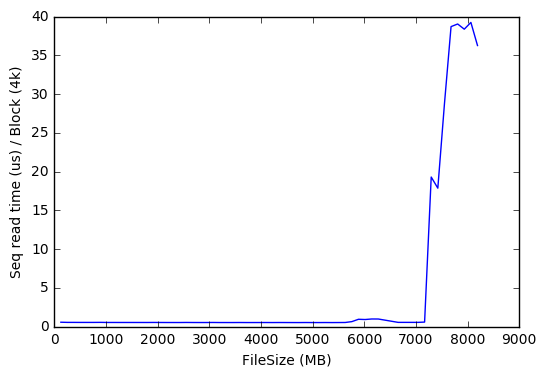

4.63397957269
11.0330157156


In [73]:
def AnalyzeFileCache(filepath):
    data = LoadData(filepath)
    avg = OrderedDict()
    
    #filter
    fdata = OrderedDict()
    for k, v in data.iteritems():
        fdata[k] = SigmaFilter(v)
    data = fdata
    
    for k, v in data.iteritems():
        avg[k>>20] = np.average(v)

    del avg[6710886400>>20]
    del avg[6845104128>>20]
    plt.plot(avg.keys(), avg.values())
    plt.xlabel('FileSize (MB)')
    plt.ylabel('Seq read time (us) / Block (4k)')
    plt.show()
    return avg
avg = AnalyzeFileCache('filecache.result')
print np.average(avg.values())
print math.sqrt(np.var(avg.values()))

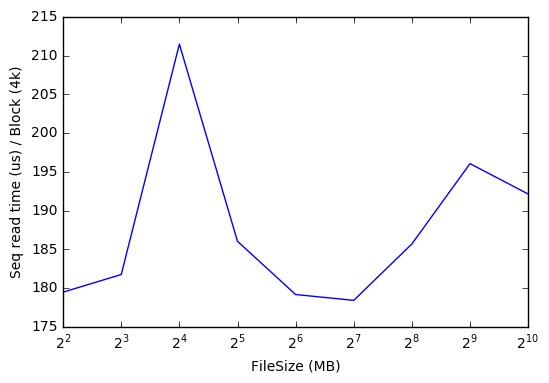

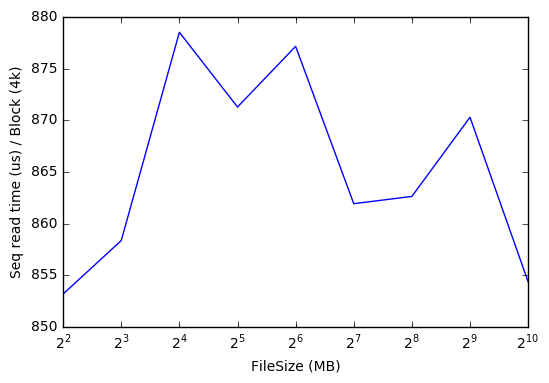

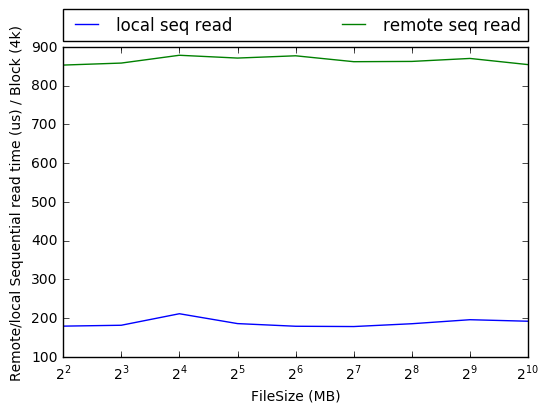

seq read avg (us) 187.814581101 standard var 10.1305426131
remote seq read avg (us) 865.301862345 stardard var 8.87385637325
seq network penalty avg (us) 677.487281243 stardard var 9.91459773285


In [66]:
def AnalyzeSeqRead(filepath):
    data = LoadData(filepath)
        
    #filter
    fdata = OrderedDict()
    for k, v in data.iteritems():
        fdata[k] = SigmaFilter(v)
    data = fdata
    
    avg = OrderedDict()
    for k, v in data.iteritems():
        avg[k>>20] = np.average(v)
        
    plt.semilogx(avg.keys(), avg.values(), label='seq read', basex=2)
    plt.xlabel('FileSize (MB)')
    plt.ylabel('Seq read time (us) / Block (4k)')
    plt.show()
    return avg

seqRead = AnalyzeSeqRead('seqread.result')
rSeqRead = AnalyzeSeqRead('rseqread.result')

plt.semilogx(seqRead.keys(), seqRead.values(), label='local seq read', basex=2)
plt.semilogx(rSeqRead.keys(), rSeqRead.values(), label='remote seq read', basex=2)
plt.xlabel('FileSize (MB)')
plt.ylabel('Remote/local Sequential read time (us) / Block (4k)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

print 'seq read', 'avg (us)', np.average(seqRead.values()), 'standard var', math.sqrt(np.var(seqRead.values()))
print 'remote seq read', 'avg (us)', np.average(rSeqRead.values()), 'stardard var', math.sqrt(np.var(rSeqRead.values()))

seqNetworkPenelty = OrderedDict()
for k, v in seqRead.iteritems():
    seqNetworkPenelty[k] = rSeqRead[k] - v
    
print 'seq network penalty', 'avg (us)', np.average(seqNetworkPenelty.values()), 'stardard var', math.sqrt(np.var(seqNetworkPenelty.values()))

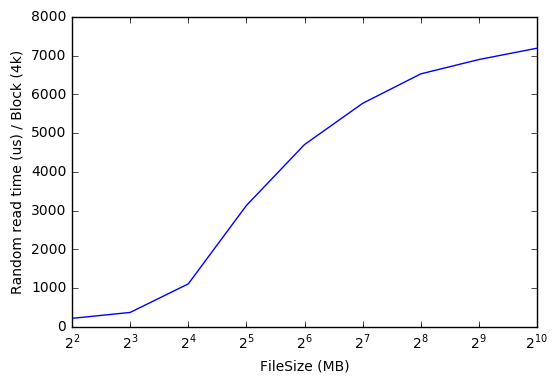

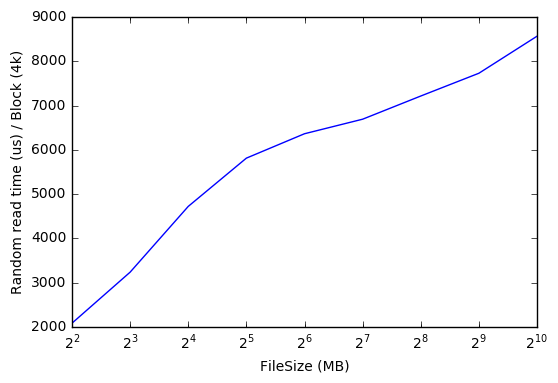

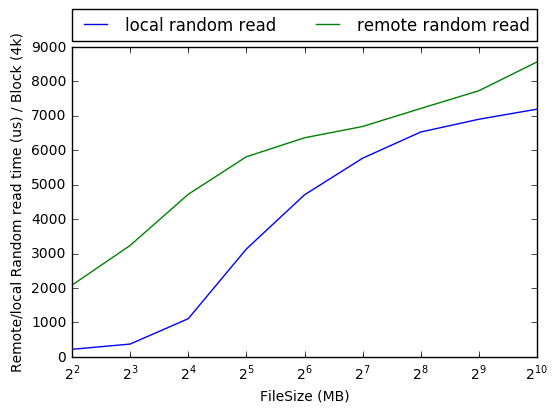

3993.27827294
5823.91893788
1830.64066494
rand read avg (us) 3993.27827294 standard var 2690.93822264
remote rand read avg (us) 5823.91893788 stardard var 2000.05609595
rand network penalty avg (us) 1830.64066494 stardard var 963.010264359


In [69]:
def AnalyzeRandRead(filepath):
    data = LoadData(filepath)
    
    #filter
    fdata = OrderedDict()
    for k, v in data.iteritems():
        fdata[k] = SigmaFilter(v)
    data = fdata
    
    avg = OrderedDict()
    for k, v in data.iteritems():
        avg[k>>20] = np.average(v)

    plt.semilogx(avg.keys(), avg.values(), label='rand read', basex=2)
    plt.xlabel('FileSize (MB)')
    plt.ylabel('Random read time (us) / Block (4k)')
    plt.show()
    return avg

randRead = AnalyzeRandRead('randread.result')
rRandRead = AnalyzeRandRead('rrandread.result')
plt.semilogx(randRead.keys(), randRead.values(), label='local random read', basex=2)
plt.semilogx(rRandRead.keys(), rRandRead.values(), label='remote random read', basex=2)
plt.xlabel('FileSize (MB)')
plt.ylabel('Remote/local Random read time (us) / Block (4k)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

print np.average(randRead.values())
print np.average(rRandRead.values())
print np.average(rRandRead.values()) - np.average(randRead.values())

print 'rand read', 'avg (us)', np.average(randRead.values()), 'standard var', math.sqrt(np.var(randRead.values()))
print 'remote rand read', 'avg (us)', np.average(rRandRead.values()), 'stardard var', math.sqrt(np.var(rRandRead.values()))

randNetworkPenelty = OrderedDict()
for k, v in randRead.iteritems():
    randNetworkPenelty[k] = rRandRead[k] - v
    
print 'rand network penalty', 'avg (us)', np.average(randNetworkPenelty.values()), 'stardard var', math.sqrt(np.var(randNetworkPenelty.values()))

def AnalyzeContentRead(filepath):
    data = LoadData(filepath)
    avg = OrderedDict()
    #print data
    for k, v in data.iteritems():
        avg[k] = np.average(v)
        print k, avg[k], math.sqrt(np.var(v))
    plt.plot(avg.keys(), avg.values(), label='contention read')
    plt.show()
    return avg

contentRead = AnalyzeContentRead('contention.result')
plt.plot(contentRead.keys(), contentRead.values(), label='measured')
plt.plot(range(1,11), [x*188 for x in range(1,11)], label='estimated')
#plt.plot(contentRandRead.keys(), contentRandRead.values(), label='random contention read')
plt.xlabel('Process number')
plt.ylabel('Contention read time (us) / Block (4k)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

1 173.952286219 6.85274923239
2 388.595146491 20.3850700831
3 626.470215212 19.3547527491
4 909.82758789 18.0770601491
5 1168.66503865 17.1432397308
6 1404.27156992 16.9808087725
7 1660.79299447 25.0582359921
8 1899.12839065 13.4993139296
9 2163.88359371 24.417393296
10 2387.32675812 25.6834547764


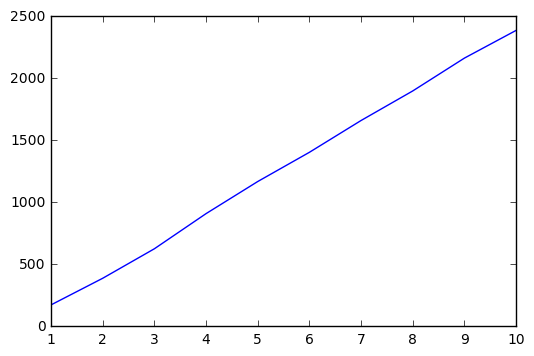

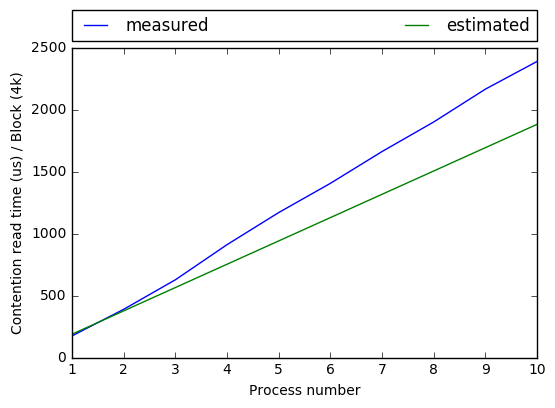

In [71]:
def AnalyzeContentRead(filepath): 
    data = LoadData(filepath) 
    avg = OrderedDict()
    #print data
    for k, v in data.iteritems():
        avg[k] = np.average(v)
        print k, avg[k], math.sqrt(np.var(v))
    plt.plot(avg.keys(), avg.values(), label='contention read')
    plt.show()
    return avg

contentRead = AnalyzeContentRead('contention.result') 
plt.plot(contentRead.keys(), contentRead.values(), label='measured') 
plt.plot(range(1,11), [x*188 for x in range(1,11)], label='estimated')
#plt.plot(contentRandRead.keys(), contentRandRead.values(), label='random contention read') 
plt.xlabel('Process number') 
plt.ylabel('Contention read time (us) / Block (4k)') 
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.) 
plt.show()

In [74]:
2*188, 4*188, 8*188

(376, 752, 1504)